In [1]:
import torch
import torchvision
from IPython import display
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

### 读取数据

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../mnist_data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../mnist_data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_works()),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_works()))


def get_dataloader_works():
    # 使用4个进程读取数据
    return 4

In [3]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 初始化模型参数

In [4]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W.shape[0]

784

### 定义softmax操作

In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

### 定义网络模型

In [6]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W)+b)

### 定义损失函数

In [7]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

### 分类精度

In [8]:
def accuracy(y_hat, y):
    # 计算预测正确的数量
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [9]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0]*n
    def add(self, *args):
        # for a, b in zip(self.data, args):
        #     print("a:"+str(a))
        #     print("b:"+str(b))
        # print(args)
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # print(self.data)
        # print("------------------------")

    def reset(self):
        self.data = [0.0]*len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

In [11]:
evaluate_accuracy(net, test_iter)

0.1127

### 训练

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型⼀个迭代周期（定义⻅第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  # @save
    """训练模型（定义⻅第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [14]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

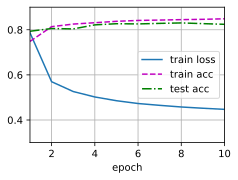

In [15]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

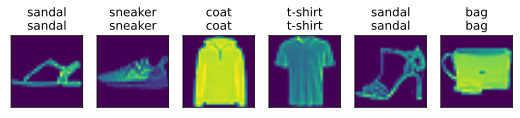

In [16]:
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义⻅第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)